to do: 

- add api call so I don't have to worry about the size of the data
- clean up the Clean section
- remove the entry errors (t5#### in activity)

# Capstone Project

## Project Definition

Investistigate the American Time Use Survey (ATUS) and Predict something tbd

Answer 3 Questions:

- Predict the occupation type for high or low autonomy occupations based on the categorized activities
- Predict the occupation type for all occupations on the categorized activities
- Predict the occupation type for all occupations on the individual activities


## Analysis

Inspiration https://github.com/hwangmpaula/data-wrangling/blob/master/wrangle_act.ipynb

### Gather

Using the ATUS data from https://www.kaggle.com/bls/american-time-use-survey I will analyse whether we see an increase in active leisure vs passive leisure with an increase in authority in the roles. 

The data forms I need are the **Activity summary** file and the **Respondent** file.

**Activity summary** from Kaggle:

> The Activity summary file contains information about the total time each ATUS respondent spent doing each activity on the diary day.

**Respondent** from Kaggle:

> The Respondent file contains information about ATUS respondents, including their labor force status and earnings.

These are already packaged in neat .csvs for data science use.

In [1]:
#import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load datasets
ATUS_sum = pd.read_csv('../data/atussum.csv') #The activity summary datafile
ATUS_resp = pd.read_csv('../data/atusresp.csv') #The respondent datafile

### Assess

**1. Quality**
(1 issues)
  - Remove rows without occupation codes

**2. Tidyness**
(3 issues)
   - Remove unnecessary columns from Respondent
   - Remove unnecessary columns from Activity Summary
   - Unify into one dataframe
   
**3. Preparation**
(3 issues)
   - Create life space categories
   - Create categorized dataframe
   - Create high and low only categorized dataframe

In [2]:
# A quick visual of the activity summary dataframe
ATUS_sum.head(10)

,tucaseid,gemetsta,gtmetsta,peeduca,pehspnon,ptdtrace,teage,telfs,temjot,teschenr,...,t181801,t181899,t189999,t500101,t500103,t500104,t500105,t500106,t500107,t509989
0,20030100013280,1,-1,44,2,2,60,2,2,-1,...,0,0,0,0,0,0,0,0,0,0
1,20030100013344,2,-1,40,2,1,41,1,2,2,...,0,0,0,0,0,0,0,0,0,0
2,20030100013352,1,-1,41,2,1,26,2,2,2,...,0,0,0,0,0,0,0,0,0,0
3,20030100013848,2,-1,39,2,2,36,4,-1,2,...,0,0,0,0,0,0,0,0,0,0
4,20030100014165,2,-1,45,2,1,51,1,2,-1,...,0,0,0,0,0,0,0,0,0,0
5,20030100014169,2,-1,43,2,1,32,2,2,1,...,0,0,0,0,0,0,0,0,0,0
6,20030100014209,1,-1,39,2,1,44,1,2,2,...,0,0,0,0,0,0,0,0,0,0
7,20030100014427,1,-1,40,2,1,21,1,2,2,...,0,0,0,0,0,0,0,0,0,0
8,20030100014550,2,-1,41,2,1,33,1,2,2,...,0,0,0,0,0,0,0,0,0,0
9,20030100014758,1,-1,41,2,2,39,1,2,2,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Get the shape of the activity summary data
ATUS_sum.shape

(170842, 455)

In [4]:
# Check the case ids for uniqueness
ATUS_sum.tucaseid.nunique()

170842

In [5]:
# Looks good. Now to figure out which is the first column with activity information
ATUS_sum_columns = ATUS_sum.columns.to_list()
ATUS_sum_columns[:30]

['tucaseid',
 'gemetsta',
 'gtmetsta',
 'peeduca',
 'pehspnon',
 'ptdtrace',
 'teage',
 'telfs',
 'temjot',
 'teschenr',
 'teschlvl',
 'tesex',
 'tespempnot',
 'trchildnum',
 'trdpftpt',
 'trernwa',
 'trholiday',
 'trspftpt',
 'trsppres',
 'tryhhchild',
 'tudiaryday',
 'tufnwgtp',
 'tehruslt',
 'tuyear',
 't010101',
 't010102',
 't010199',
 't010201',
 't010299',
 't010301']

In [6]:
# 't010101' is the first activity column (which matches the data dictionary)
# Setting it's location in a variable for later
act_start = ATUS_sum_columns.index('t010101')

In [7]:
# Checking for any NaN values in the data I'll be using
ATUS_sum[ATUS_sum_columns[act_start:]].isnull().sum().sort_values(ascending=False)

t509989    0
t060101    0
t060103    0
t060104    0
t060199    0
          ..
t130136    0
t130199    0
t130201    0
t130202    0
t010101    0
Length: 431, dtype: int64

In [8]:
# No NaNs, good sign.
# 
ATUS_sum['t010101'].value_counts()

480     10495
540     10296
510      8708
600      7467
450      7225
        ...  
1088        1
961         1
1089        1
1345        1
1023        1
Name: t010101, Length: 1120, dtype: int64

In [9]:
# A quick visual of the respondent dataframe
ATUS_resp.head(10)

,tucaseid,tulineno,tespuhrs,trdtind1,trdtocc1,trernhly,trernupd,trhernal,trhhchild,trimind1,...,tryhhchild,trwbmodr,trtalone_wk,trtccc_wk,trlvmodr,trtec,tuecytd,tuelder,tuelfreq,tuelnum
0,20030100013280,1,-1.0,40,8,2200.0,1,1,2,15,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,20030100013344,1,50.0,16,16,-1.0,1,-1,1,5,...,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,20030100013352,1,-1.0,43,15,1250.0,0,0,2,16,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,20030100013848,1,40.0,-1,-1,-1.0,-1,-1,1,-1,...,9,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,20030100014165,1,-1.0,42,10,-1.0,-1,-1,1,16,...,14,-1,-1,-1,-1,-1,-1,-1,-1,-1
5,20030100014169,1,40.0,40,8,-1.0,1,-1,1,15,...,2,-1,-1,-1,-1,-1,-1,-1,-1,-1
6,20030100014209,1,50.0,43,15,-1.0,-1,-1,1,16,...,9,-1,-1,-1,-1,-1,-1,-1,-1,-1
7,20030100014427,1,-1.0,41,11,950.0,0,0,1,16,...,14,-1,-1,-1,-1,-1,-1,-1,-1,-1
8,20030100014550,1,40.0,34,17,1400.0,0,0,1,12,...,3,-1,-1,-1,-1,-1,-1,-1,-1,-1
9,20030100014758,1,-1.0,41,11,1200.0,0,0,1,16,...,4,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [10]:
#get the shape of the respondent data
ATUS_resp.shape

(170842, 132)

In [11]:
#check the case ids for uniqueness
ATUS_resp.tucaseid.nunique()

170842

In [12]:
#check how many rows are without an occupation code (trdtocc1), which is listed in the data as -1
ATUS_resp['trdtocc1'].value_counts()

-1     64220
 17    14068
 1     12867
 16    10649
 8      7735
 10     6174
 21     6078
 22     5504
 2      5288
 19     4775
 13     4337
 14     3966
 15     3796
 20     3399
 3      3115
 11     2463
 4      2336
 12     2246
 9      2238
 6      2124
 7      1462
 5      1226
 18      776
Name: trdtocc1, dtype: int64

Unfortunately, most of the occupation cells are blank.

Lastly, in order to answer the questions, we need to categorize the activites into Parker's six 'life space' categories. More on this in the **Clean** section below.

### Clean

Method for each assess issue

 - Define the problem
 - Code the solution
 - Test the solution

**Remove rows without occupation codes - Define**

Rows without occupation codes are not useful in this investigation. All rows with `-1` in the `trdtocc1` tab need to be removed.

**Remove rows without occupation codes - Code**

In [13]:
o = ATUS_resp.query('trdtocc1 != -1')

**Remove rows without occupation codes - Test**

In [14]:
o.trdtocc1.value_counts()

17    14068
1     12867
16    10649
8      7735
10     6174
21     6078
22     5504
2      5288
19     4775
13     4337
14     3966
15     3796
20     3399
3      3115
11     2463
4      2336
12     2246
9      2238
6      2124
7      1462
5      1226
18      776
Name: trdtocc1, dtype: int64

**Remove unnecessary columns in Respondent - Define**

Keep only the occupation related categories --EDIT

**Remove unnecessary columns in Respondent - Code**

In [15]:
c = o[['tucaseid','trdtocc1']]

**Remove unnecessary columns in Respondent - Test**

In [16]:
c.head(10)

,tucaseid,trdtocc1
0,20030100013280,8
1,20030100013344,16
2,20030100013352,15
4,20030100014165,10
5,20030100014169,8
6,20030100014209,15
7,20030100014427,11
8,20030100014550,17
9,20030100014758,11
10,20030100014928,16


**Remove unnecessary columns in Activity summary - Define**

For **Activity summary** I do not need any columns that contain data on the respondant, I only need to know what their time spent doing the individual activities

**Remove unnecessary columns in Activity summary - Code**

In [19]:
a = ATUS_sum.drop(columns=ATUS_sum_columns[1:act_start])

**Remove unnecessary columns in Activity summary - Test**

In [20]:
a.head()

,tucaseid,t010101,t010102,t010199,t010201,t010299,t010301,t010399,t010401,t010499,...,t181801,t181899,t189999,t500101,t500103,t500104,t500105,t500106,t500107,t509989
0,20030100013280,870,0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20030100013344,620,0,0,60,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20030100013352,560,0,0,80,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20030100013848,720,0,0,35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20030100014165,385,0,0,75,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Make one new database - Define**

make one database for the analysis - EDIT

**Make one new database - Code**

In [21]:
ATUS_data = c.set_index('tucaseid').join(a.set_index('tucaseid'))

**Make one new database - Test**

In [22]:
ATUS_data.head()

,trdtocc1,t010101,t010102,t010199,t010201,t010299,t010301,t010399,t010401,t010499,...,t181801,t181899,t189999,t500101,t500103,t500104,t500105,t500106,t500107,t509989
tucaseid,,,,,,,,,,,,,,,,,,,,,
20030100013280,8,870,0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20030100013344,16,620,0,0,60,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20030100013352,15,560,0,0,80,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20030100014165,10,385,0,0,75,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20030100014169,8,675,0,0,35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#check for correct shape
ATUS_data.shape

(106622, 432)

**Create life space categories - Define**

Stanley Robert Parker's Future of Leisure (1971) lays out six components of 'life space': **Work**, **Work obligations**, **Physiological needs**, **Non-work obligations**, **Leisure**, **Leisure-in-work**.

According to Parker:
>'Life space' means the total of activities or ways of spending time that people have.
	
I've classified the activities included in the American Time Use Survey in these categories, I have listed the breakdown below.

**Work**
_working time, sold time, substinence time_

Time spent in employment, 'earning a living' for the worker and their dependants. 

50101


**Work obligations**
_Work-related time_

Activities around work, but not during employment. Examples include communting to work or grooming for work.

All 5 except 501


**Physiological needs**
_Existence time_

The necessitities of life, eating, sleeping, eliminating, etc.

All 1, 11


**Non-work obligations**
_semi-work_

All 2, 3, 4, 6, 8, 9, 10, 14, 15, 16, 18 except 1805

Activities that we once leisure but have taken the character of obligations. These are often obligations toward other people. 

**Leisure**
_free time, spare time, uncommitted time, discretionary time, choosing time_

With two subcategories, **Active leisure** and **Passive leisure**.

**Active leisure** is more engaged and creative.

120101, 120199, 120201, 120202, 120299, 120309, 120310, 120311, 120312, 120313, 120399, 120401, 120402, 120403, 120404, 120405, 120499, 120502, 120503, 120504, 120599, 129999, All 1301

**Passive leisure** is more consumptive and less engaged

120301, 120302, 120303, 120304, 120305, 120306, 120307, 120308
All 7, 1302, 1303, 1304

For simplicity's sake, **Leisure-in-work** will be classified with **Work obligations**.

**Create life space categories - Code**

In [24]:
#get the list of columns
data_columns = ATUS_data.columns.tolist()
#remove occupation (trdtocc1) column
data_columns.pop(0)

#create new lists
work = []
work_obligations = []
physiological_needs = []
non_work_obligations = []
active_leisure = []
passive_leisure = []

for i in range(len(data_columns)):
    #classify into work
    if data_columns[i] == "t050101":
        work.append(data_columns[i])
    #classify into work obligations
    elif ((data_columns[i].find('t05') != -1) and (data_columns[i] != '150501')) or (data_columns[i] == 't180501'):
        work_obligations.append(data_columns[i])
    #classify into physiological needs
    elif (data_columns[i].find('t01') != -1) or (data_columns[i].find('t11') != -1):
        physiological_needs.append(data_columns[i])
    #classify non-work obligations
    elif (data_columns[i].find('t02') != -1) or (data_columns[i].find('t03') != -1):
        non_work_obligations.append(data_columns[i])
    elif (data_columns[i].find('t04') != -1) or (data_columns[i].find('t06') != -1):
        non_work_obligations.append(data_columns[i])
    elif (data_columns[i].find('t06') != -1) or (data_columns[i].find('t08') != -1):
        non_work_obligations.append(data_columns[i])
    elif (data_columns[i].find('t09') != -1) or (data_columns[i].find('t10') != -1):
        non_work_obligations.append(data_columns[i])
    elif (data_columns[i].find('t14') != -1) or (data_columns[i].find('t15') != -1):
        non_work_obligations.append(data_columns[i])
    elif (data_columns[i].find('t16') != -1) or ((data_columns[i].find('t18') != -1) and (data_columns[i] != 't180501')):
        non_work_obligations.append(data_columns[i])
    #classify active leisure
    elif (data_columns[i].find('t1201') != -1) or (data_columns[i].find('t1202') != -1):
        active_leisure.append(data_columns[i])
    elif (data_columns[i].find('t12031') != -1) or (data_columns[i].find('t12039') != -1):
        active_leisure.append(data_columns[i])
    elif (data_columns[i].find('t1204') != -1) or (data_columns[i].find('t1205') != -1):
        active_leisure.append(data_columns[i])
    elif (data_columns[i].find('t1299') != -1) or (data_columns[i].find('t1301') != -1):
        active_leisure.append(data_columns[i])
    elif (data_columns[i].find('t1399') != -1) or (data_columns[i] == 't120309'):
        active_leisure.append(data_columns[i])
    #classify passive leisure
    elif (data_columns[i].find('t07') != -1) or (data_columns[i].find('t1302') != -1):
        passive_leisure.append(data_columns[i])
    elif (data_columns[i].find('t1303') != -1) or (data_columns[i].find('t1304') != -1):
        passive_leisure.append(data_columns[i])
    elif (data_columns[i].find('t12030') != -1) and (data_columns[i] != 't120309'):
        passive_leisure.append(data_columns[i])


**Create life space categories - Test**

In [25]:
len(data_columns) - 7

424

In [26]:
len(work) + len(work_obligations) + len(physiological_needs) + len(non_work_obligations) + len(active_leisure) + len(passive_leisure)

424

**Create categorized dataframe - Define**

Creating the dataframe for the categorized measuring something - EDIT

**Create categorized dataframe - Code**

In [27]:
ATUS_category_data = ATUS_data[['trdtocc1','t010101']]

In [28]:
life_space_categories = [work, work_obligations, physiological_needs, non_work_obligations, active_leisure, passive_leisure]
life_space_titles = ['Work', 'Work Obligations', 'Physiological Needs', 'Non-work Obligations', 'Active Leisure', "Passive Leisure"]


for i in range(len(life_space_categories)):
    ATUS_category_data.insert(loc=ATUS_category_data.shape[1],column=life_space_titles[i], value=ATUS_data[life_space_categories[i]].sum(axis=1))

In [29]:
ATUS_category_data = ATUS_category_data.drop(columns='t010101')

**Create categorized dataframe - Test**

In [30]:
ATUS_category_data.head()

,trdtocc1,Work,Work Obligations,Physiological Needs,Non-work Obligations,Active Leisure,Passive Leisure
tucaseid,,,,,,,
20030100013280,8,0,0,915,0,200,325
20030100013344,16,0,0,770,80,530,60
20030100013352,15,0,0,715,325,220,180
20030100014165,10,500,15,552,253,60,60
20030100014169,8,0,0,775,360,195,110


**Create high and low only categorized dataframe - Define**

Users who are not in the [High Autonomy Category] or the [Low Autonomy Category] will be removed for ease of analysis --EDIT

**Create high and low only categorized dataframe - Code**

In [31]:
ATUS_category_data_lite = ATUS_category_data.query('trdtocc1 == 1 or trdtocc1 == 22')

**Create high and low only categorized dataframe - Test**

In [32]:
ATUS_category_data_lite['trdtocc1'].value_counts()

1     12867
22     5504
Name: trdtocc1, dtype: int64

### Analyze
inspired by Data Driven Science and Engineering by Steve L. Brunton and J. Nathan Kutz 
http://www.databookuw.com/

In [34]:
b = ATUS_category_data_lite['trdtocc1'] # occupations
A = ATUS_category_data_lite.drop(columns=['trdtocc1']) # activities

In [35]:
U, S, VT = np.linalg.svd(A,full_matrices=0)
U.shape, np.diag(S).shape, VT.shape

((18371, 6), (6, 6), (6, 6))

In [36]:
x = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ b

### Model

inspired by Data Driven Science and Engineering by Steve L. Brunton and J. Nathan Kutz 
http://www.databookuw.com/

### Visualize

inspired by Data Driven Science and Engineering by Steve L. Brunton and J. Nathan Kutz 
http://www.databookuw.com/

<ipython-input-38-2837d052d61d>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(b, Color='k', LineWidth=2, label='Occupation') # True relationship
<ipython-input-38-2837d052d61d>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(A@x, '-o', Color='r', LineWidth=1.5, MarkerSize=6, label='Regression')


TypeError: '(slice(None, None, None), -1)' is an invalid key

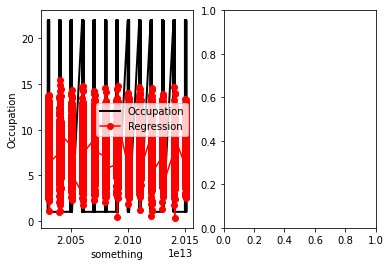

In [38]:
fig = plt.figure()
ax1 = fig.add_subplot(121)

plt.plot(b, Color='k', LineWidth=2, label='Occupation') # True relationship
plt.plot(A@x, '-o', Color='r', LineWidth=1.5, MarkerSize=6, label='Regression')
plt.xlabel('something')
plt.ylabel('Occupation')
plt.legend()

ax2 = fig.add_subplot(122)
sort_ind = np.argsort(ATUS_category_data_lite[:,-1])
b = b[sort_ind] # sorted values
plt.plot(b, Color='k', LineWidth=2, label='Housing Value') # True relationship
plt.plot(A[sort_ind,:]@x, '-o', Color='r', LineWidth=1.5, MarkerSize=6, label='Regression')
plt.xlabel('Neighborhood')
plt.legend()

plt.show()

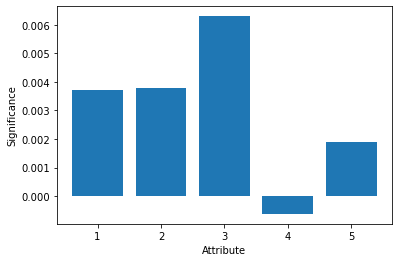

In [39]:
x_tick = range(len(x)-1)+np.ones(len(x)-1)
plt.bar(x_tick,x[:-1])
plt.xlabel('Attribute')
plt.ylabel('Significance')
plt.xticks(x_tick)
plt.show()